In [1]:
Mjj_selection = 1000.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# def computeDiscriminatingVar(x):
#     out = x[:,-2]+x[:,-1]
#     return out*1e4

# Imports

In [2]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
from prettytable import PrettyTable

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

Welcome to JupyROOT 6.16/00


# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(38568, 13)


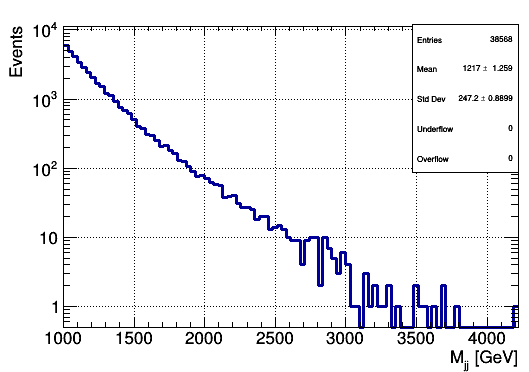

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=5,
                                tol=1e-5,
                                verbose=2)

x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
gbr_cut.fit(x, y);

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

      Iter       Train Loss   Remaining Time 
         1           0.3975            1.74s
         2           0.3970            2.35s
         3           0.3967            2.10s
         4           0.3963            2.14s
         5           0.3960            1.98s
         6           0.3957            1.97s
         7           0.3955            1.93s
         8           0.3953            1.86s
         9           0.3951            1.93s
        10           0.3949            1.87s
        11           0.3948            1.80s
        12           0.3947            1.74s
        13           0.3946            1.71s


['../models/gbr_cut_trained_20190807.joblib']

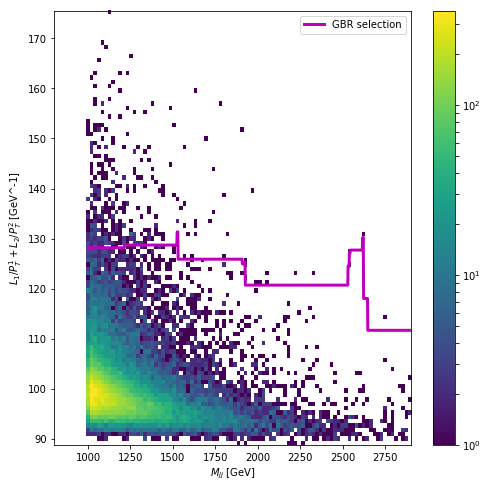

In [5]:
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
# plt.ylabel('VAE score')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [6]:
# ## Talk plot ###
# matplotlib.rcParams.update({'font.size': 22})
# plt.figure(figsize=(8, 6))
# x_min = Mjj_selection*0.8
# x_max = np.quantile(x, 0.999)
# plt.hist2d(x[:,0], y,
#            range=((x_min , x_max), (np.min(y), np.quantile(y, 1-5e-3))), 
#            norm=LogNorm(), bins=100,
#            label='Side band data'
#           )

# xs = np.arange(Mjj_selection-10, x_max, 0.01*(x_max-Mjj_selection))
# ys = gbr_cut.predict(np.reshape(xs, (-1,1)))
# plt.plot(xs, ys, '-', color='m', lw=3, label='VAE selection')
# plt.fill_between(xs, np.min(y)*np.ones_like(ys), ys, color='white', alpha=0.5)
# plt.fill_between(xs, ys, np.quantile(y, 1-5e-3), color='red', alpha=0.15)

# plt.ylabel('VAE score')
# plt.xlim(990, x_max)
# plt.xlabel('$M_{jj}$ [GeV]')
# plt.legend(loc='best')
# plt.draw()

In [7]:
# h1 = create_TH2D(np.column_stack((x[:,0], y)), 
#                  binning=[10, x_min , x_max, 100, np.min(y)-10, 10+np.quantile(y, 1-1e-4)])
# h1.SetStats(0)
# h1.SetBarWidth(4);
# h1.SetFillStyle(0);
# h1.SetFillColor(rt.kGray);
# h1.SetLineColor(rt.kBlue);

# c_2D = create_Canvas('c2D', size=(600,600))
# h1.Draw('violinx(12000000)')
# c_2D.Draw()
# c_2D.SetLogz()

In [8]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

In [14]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title='', canvas_size=(600,400)):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title, canvas_size=canvas_size)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

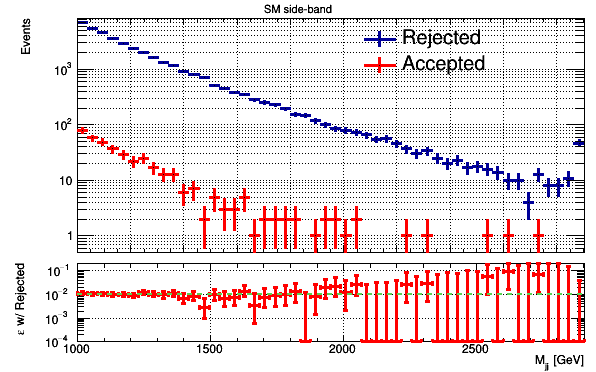

In [16]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'SM side-band', canvas_size=(600,400))
h_a = c.h_list[1]
h_r = c.h_list[0]
c.SaveAs('~/Desktop/SMsideband.root')

# Define and test Hypotesis test

In [11]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=False):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs)
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')

    return p_val

In [12]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

S obs: 73.3550669312166
Test stat reached after 1 loops


0.6785

# Analyze signal region

In [17]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':r'QCD',
                'AtoZZZ':r'$A\to ZZZ$',
                'GtoWW':r'$G\to WW$',
                'GtoBtt':r'$G_{B}\to t\bar{t}$',
                'GtoNtt':r'$G_{N}\to t\bar{t}$'
               }

sample_label_ROOT = {'qcd':'QCD',
                'AtoZZZ':'A #rightarrow ZZZ',
                'GtoWW':'G #rightarrow WW',
                'GtoBtt':'G_{B} #rightarrow t#bar{t}',
                'GtoNtt':'G_{N} #rightarrow t#bar{t}'
               }

SM_samples = ['qcd']
BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

sample_nGenEvts = {'qcd': 418*10000,
                   'AtoZZZ': 100*1000,
                   'GtoWW': 100*1000,
                   'GtoBtt': 96*1000,
                   'GtoNtt': 96*1000
                  }

sample_xsec = {'qcd': 8734.0 #pb
              }

### Get the data

In [18]:
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100*sample_eff[n]), np.sum(data[n]['sel']), eff])
    
print(table)

+--------+----------+--------------+---------------+-------------+
| Sample | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+--------+----------+--------------+---------------+-------------+
| GtoBtt |  65082   |     67.8     |     13615     |    20.92    |
| GtoWW  |  52408   |     52.4     |     11434     |    21.82    |
| GtoNtt |  63748   |     66.4     |     13376     |    20.98    |
| AtoZZZ |  63490   |     63.5     |     14316     |    22.55    |
|  qcd   |  86911   |     2.1      |      881      |     1.01    |
+--------+----------+--------------+---------------+-------------+


### Define utilitities

In [19]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sample_label_ROOT[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f} %'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [20]:
lumi = 100 #pb^-1

N_asymov = 10000
# N_asymov = int(1 / (1 - erf(5.5/np.sqrt(2))))
N_exp_per_xsec = 1

In [21]:
dic_p_val = {}
rt.gROOT.SetBatch(True)



GtoWW
xsec BSM 1.0e-01 pb
Experiment: 0
S obs: 64.38306831556281
Test stat reached after 1 loops
xsec BSM 2.2e-01 pb
Experiment: 0
S obs: 68.15740180197727
Test stat reached after 1 loops
xsec BSM 4.6e-01 pb
Experiment: 0
S obs: 79.52802060158953
Test stat reached after 8 loops
xsec BSM 1.0e+00 pb
Experiment: 0
S obs: 85.03219435891626
90000 5
Increasing by a factor 5 the number of asymov per loop
590000 16
Test stat reached after 24 loops
xsec BSM 2.2e+00 pb
Experiment: 0
S obs: 79.36214316943634
Test stat reached after 5 loops
xsec BSM 4.6e+00 pb
Experiment: 0
S obs: 102.12845337869975
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
xsec BSM 1.0e+01 pb
Experiment: 0
S obs: 129.99111918754792
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.


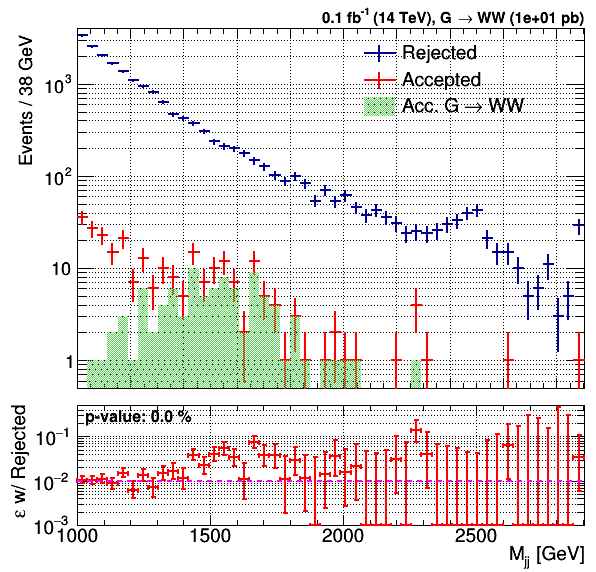

In [22]:
for name_BSM in BSM_samples:
    if name_BSM != 'GtoWW':
        continue
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    for xsec_BSM in np.logspace(-1, 1, 7): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec):
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]:
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx]))
                d_obs = np.concatenate((d_obs, d_aux))

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow'
                                )

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow'
                                    )
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = '../fig/ModelIndependentAnalysis/massSpectrum/'
                fig_name += name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                c.SaveAs(fig_name + '.png')

        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)

# Make the p-value plot

In [ ]:
sample_col = {
              'AtoZZZ':'r',
              'GtoWW':'b',
              'GtoBtt':'g',
              'GtoNtt':'c'
             }

In [ ]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='upper right')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')

fig.savefig('../fig/ModelIndependentAnalysis/' + 'pValueScan_L' + str(lumi) + 'pb-1.png', bbox_inches='tight')